# Project: Time Series Analysis and short-term prediction on weather data for Berlin-Temelhof 
#### (Feb. 2023 - Britta Schmitt)
In this project, we first load, analyze and engineer original weather data set we downloaded on ecad.eu for Berlin Tempelhof. We find that we deal with daily data starting on 01-01-1876, ending on 12-31-2022. Note that some data is missing in the time where WW2 took place (we neglect that data). 

After making a train-test split, we run a regression model on trend and seasonality, and extract the remainder afterwards. On the remainder, we run an autoregressive model (after checking for stationarity). 
We then evaluate the model via cross-validation and test it on the test data. Finally, we make a short-term prediction based on the introduced model. 


In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (14,6)

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import statsmodels
from statsmodels.tsa import stattools


# 1) Load, investigate and clean the data

In [28]:
df = pd.read_csv('ECA_blended_custom/TG_STAID002759_clean.txt', sep=",", index_col=1, parse_dates=True)

# columns:
# SOUID: source identifier
# DATE: DATE YYYYMMDD
# TG: mean temp in 0.1 degr. Celcius
# Q_TG: quality code for TG (0: 'valid', 1: 'suspect', 9: 'missing')

In [29]:
#get overview on data
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [3]:
#print column names
for col in df.columns:
    print(col)

 SOUID
   TG
 Q_TG


In [30]:
#rename columns to get rid off empty spaces
df.rename(str.strip, axis='columns', inplace=True) #remove white space from column names

In [18]:
#inspect data for missing values
df[df['Q_TG']==9]

,SOUID,TG,Q_TG
DATE,,,
1945-04-25,127488,-9999,9
1945-04-26,127488,-9999,9
1945-04-27,127488,-9999,9
1945-04-28,127488,-9999,9
1945-04-29,127488,-9999,9
...,...,...,...
1945-11-01,127488,-9999,9
1945-11-02,127488,-9999,9
1945-11-03,127488,-9999,9


In [31]:
#recheck that index is in datetime format
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Scale Temperature with factor 0.1 (degr. Celcius) and add to dataframe**

In [32]:
#set up new column containing data in degree celcius format
df['TG_scaled'] = df.iloc[:,1]*0.1

In [33]:
#drop column SOUID as it does not contain any neccesary data
df.drop('SOUID', axis=1, inplace=True)

In [34]:
df.head()

,TG,Q_TG,TG_scaled
DATE,,,
1876-01-01,22,0,2.2
1876-01-02,25,0,2.5
1876-01-03,3,0,0.3
1876-01-04,-58,0,-5.8
1876-01-05,-98,0,-9.8


**Drop lines where there is no data available, as it's only 195 lines**

In [35]:
df = df.loc[df["Q_TG"] != 9]
df.shape

(53496, 3)

In [240]:
#get some statistics on data
df.describe()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000,53496.000000
mean,94.118233,9.411823,26747.500000,0.077613,0.085184,0.082324,0.084604,0.081875,0.084604,0.084604,0.081875,0.084604,0.082343,0.085184
std,78.795811,7.879581,15443.109337,0.267565,0.279158,0.274860,0.278295,0.274177,0.278295,0.278295,0.274177,0.278295,0.274889,0.279158
min,-226.000000,-22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.400000,13373.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.000000,9.400000,26747.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,158.000000,15.800000,40121.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,305.000000,30.500000,53495.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
#drop quality code as it does not contain any useful information
df.drop('Q_TG', axis=1, inplace=True)

In [38]:
df.head()

,TG,TG_scaled
DATE,,
1876-01-01,22,2.2
1876-01-02,25,2.5
1876-01-03,3,0.3
1876-01-04,-58,-5.8
1876-01-05,-98,-9.8


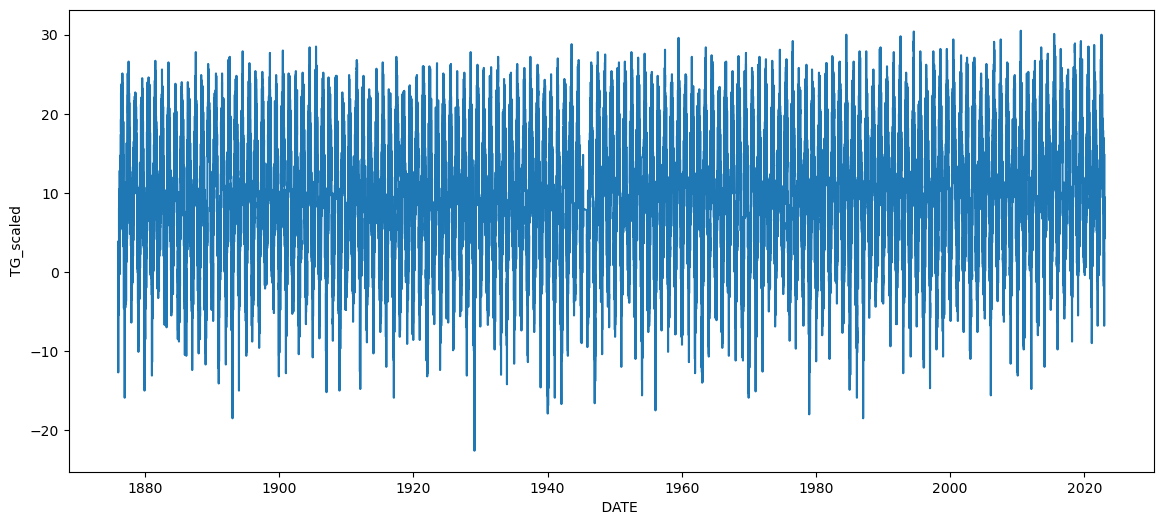

In [39]:
#plot time series data to get overview 
sns.lineplot(data=df, x=df.index, y="TG_scaled");

In [40]:
#transfer info contained in datetime index to new column
#df["MONTH"] = df['DATE'].dt.month
df["month"] = df.index.month
df.head()

,TG,TG_scaled,month
DATE,,,
1876-01-01,22,2.2,1
1876-01-02,25,2.5,1
1876-01-03,3,0.3,1
1876-01-04,-58,-5.8,1
1876-01-05,-98,-9.8,1


##  Extract timestep and seasonal dummies

In [49]:
#insert timestep column based on datetime index
df['timestep'] = list(range(len(df)))
df.head()

,TG,TG_scaled,month,timestep
DATE,,,,
1876-01-01,22,2.2,1,0
1876-01-02,25,2.5,1,1
1876-01-03,3,0.3,1,2
1876-01-04,-58,-5.8,1,3
1876-01-05,-98,-9.8,1,4


In [50]:
#insert columns based on one-hot-encoding the information on month
seasonal_dummies = pd.get_dummies(df.index.month,
                              prefix='month',
                              drop_first=True).set_index(df.index)

In [51]:
#concatenate new dummy variables to original dataframe
df = df.join(seasonal_dummies)

In [53]:
#drop column on month information in order to prevent recurrent information in dataframe
df.drop('month', axis=1, inplace=True)

In [54]:
df.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,
1876-01-01,22,2.2,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0


# 1.1) Train-Test-Split

In [55]:
#print year information to decide which data to use as test set
print(df.index.year.max())
df.index.year.min()

2022


1876

In [57]:
#split data to train and test set: for testing, choose all data from 
#the last year that is contained in the data set (i.e., last 365 days)
dftrain = df[:-365]
dftest = df[-365:]

In [58]:
#check whether everthing worked
dftrain.tail()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,
2021-12-27,-39,-3.9,53126,0,0,0,0,0,0,0,0,0,0,1
2021-12-28,-5,-0.5,53127,0,0,0,0,0,0,0,0,0,0,1
2021-12-29,45,4.5,53128,0,0,0,0,0,0,0,0,0,0,1
2021-12-30,93,9.3,53129,0,0,0,0,0,0,0,0,0,0,1
2021-12-31,130,13.0,53130,0,0,0,0,0,0,0,0,0,0,1


In [59]:
#check whether everthing worked
dftest.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,
2022-01-01,120,12.0,53131,0,0,0,0,0,0,0,0,0,0,0
2022-01-02,99,9.9,53132,0,0,0,0,0,0,0,0,0,0,0
2022-01-03,89,8.9,53133,0,0,0,0,0,0,0,0,0,0,0
2022-01-04,64,6.4,53134,0,0,0,0,0,0,0,0,0,0,0
2022-01-05,38,3.8,53135,0,0,0,0,0,0,0,0,0,0,0


# 2) Model the trend

In [60]:
from sklearn.linear_model import LinearRegression

In [71]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,
1876-01-01,22,2.2,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0


In [72]:
# Define X and y
Xtrain_trend = dftrain[['timestep']]
ytrain_trend = dftrain['TG_scaled']

In [73]:
#choose linear regression as first model
m = LinearRegression()

In [74]:
m.fit(Xtrain_trend,ytrain_trend)

LinearRegression()

In [75]:
#make predictions and insert prediction to training dataframe
dftrain['trend'] = m.predict(Xtrain_trend)

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/2414284145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain['trend'] = m.predict(Xtrain_trend)


In [76]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend
DATE,,,,,,,,,,,,,,,
1876-01-01,22,2.2,0,0,0,0,0,0,0,0,0,0,0,0,8.499051
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,8.499085
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,8.499119
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,8.499153
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,8.499186


# 3) Plot trend and original data

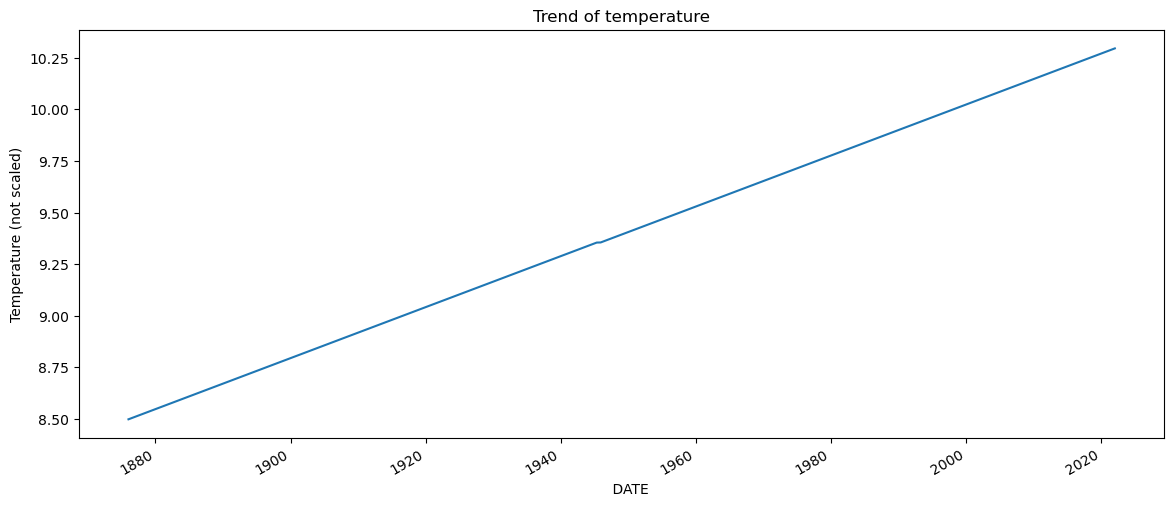

In [77]:
#plot trend
dftrain['trend'].plot()
plt.title('Trend of temperature')
plt.ylabel('Temperature (not scaled)');

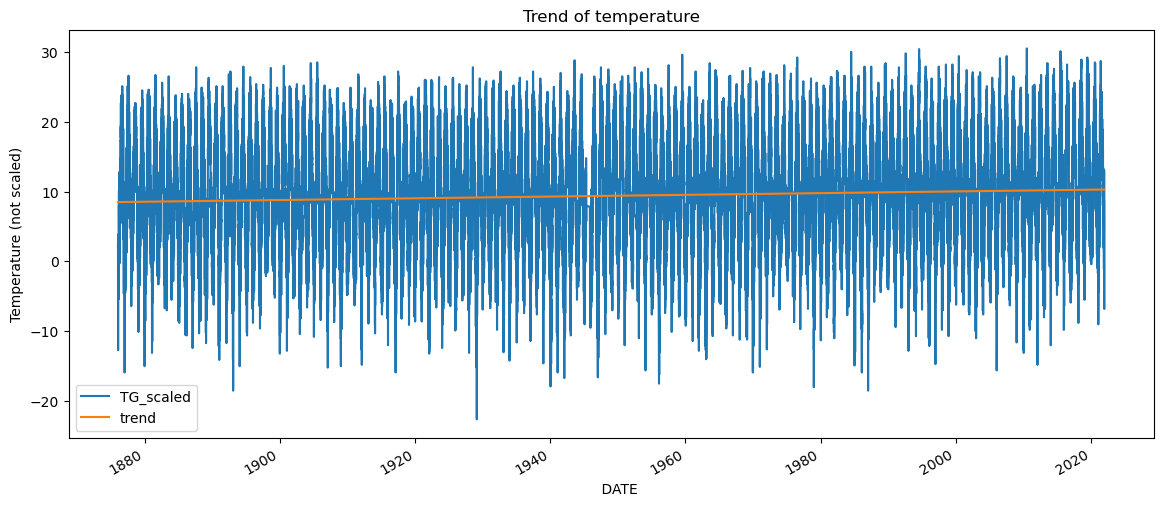

In [79]:
#plot trend vs. original data
dftrain[['TG_scaled','trend']].plot()
plt.title('Trend of temperature')
plt.ylabel('Temperature (not scaled)');

# 4) Model seasonality (including trend)

We already attached a column including the indication of month per year (1-12). Now, we take this information into account to model seasonality and trend! 
To do so, we do some feature expansion (OHE on month).

In [80]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend
DATE,,,,,,,,,,,,,,,
1876-01-01,22,2.2,0,0,0,0,0,0,0,0,0,0,0,0,8.499051
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,8.499085
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,8.499119
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,8.499153
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,8.499186


In [82]:
#prepare X for training containing seasonal info and timestep
Xtrain_season = dftrain.drop(columns=['TG','TG_scaled','trend'])

In [83]:
Xtrain_season.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0


In [85]:
ytrain_season = pd.DataFrame(ytrain_trend)
ytrain_season.head()

,TG_scaled
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [86]:
#choose linear regression as model 
m_trend_seasonal = LinearRegression()

In [87]:
m_trend_seasonal.fit(Xtrain_season,ytrain_season)

LinearRegression()

In [88]:
#predict seasonal trend and attach info to dataframe
dftrain['trend_seasonal'] = m_trend_seasonal.predict(Xtrain_season)

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/3056041012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain['trend_seasonal'] = m_trend_seasonal.predict(Xtrain_season)


In [90]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_seasonal
DATE,,,,,,,,,,,,,,,,
1876-01-01,22,2.2,0,0,0,0,0,0,0,0,0,0,0,0,8.499051,-0.878001
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,8.499085,-0.877968
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,8.499119,-0.877935
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,8.499153,-0.877902
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,8.499186,-0.877869


# 5) Plot original data vs. trend + seasonal 

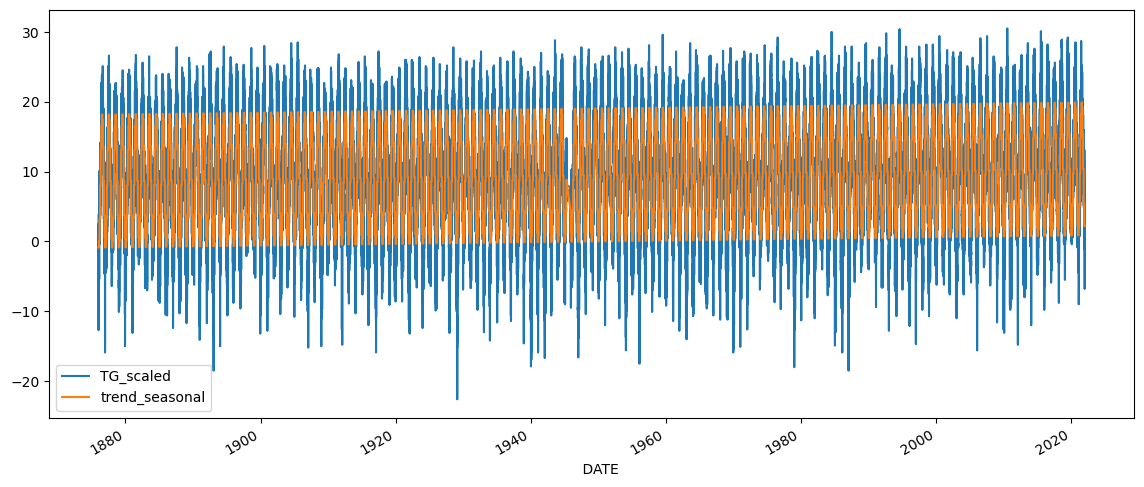

In [91]:
dftrain[['TG_scaled','trend_seasonal']].plot();

To get a better overview on the data, let's have a look at the first two years included in the dataset (thus, plot 740 days / timesteps)

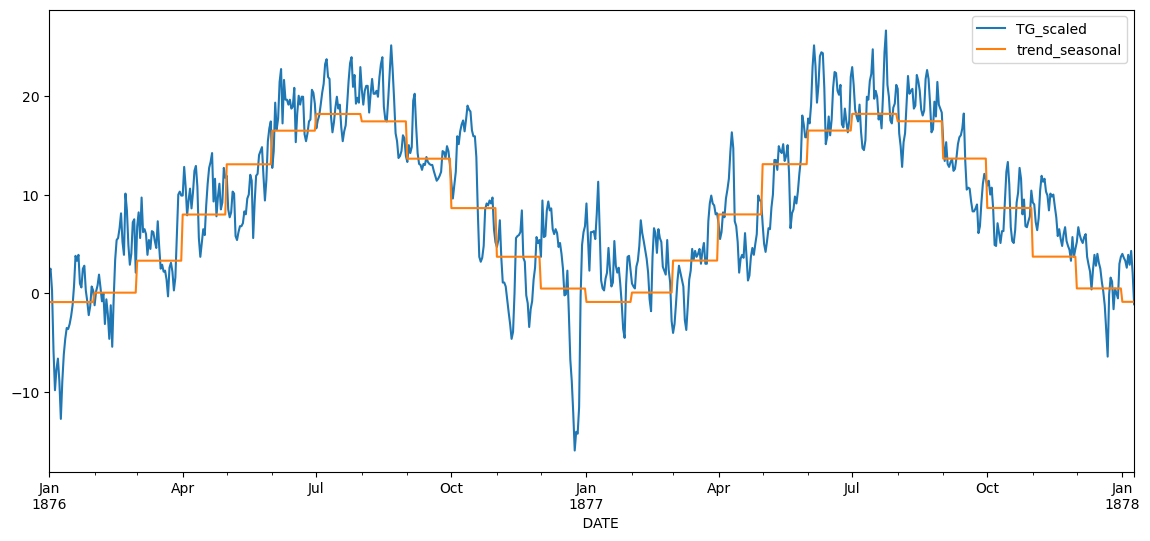

In [94]:
dftrain.iloc[0:740,:][['TG_scaled','trend_seasonal']].plot();

# 6) Extract remainder

We extract the remainder in order to adjust our model better to the data

In [95]:
#insert a new column that contains the remainder information
dftrain['remainder']=dftrain['TG_scaled'] - dftrain['trend_seasonal']

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/1557936089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain['remainder']=dftrain['TG_scaled'] - dftrain['trend_seasonal']


Text(0.5, 1.0, 'Remainder after modeling trend and seasonality')

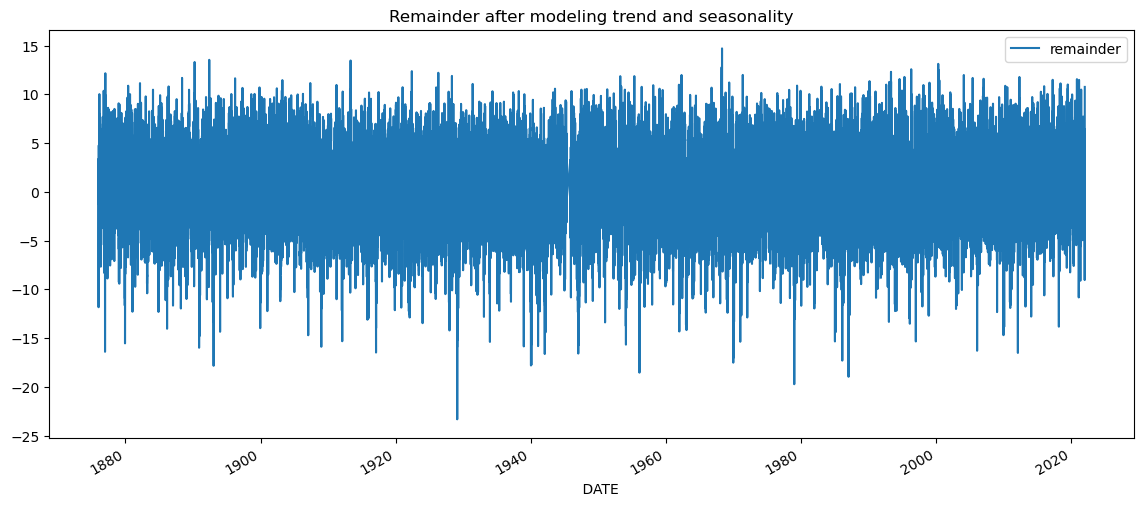

In [97]:
#plot the remainder
dftrain[['remainder']].plot();
plt.title('Remainder after modeling trend and seasonality');

In [99]:
#get some statistics information on remainder
dftrain.remainder.mean(), dftrain.remainder.std()

(1.0039420145209146e-15, 3.9290195596593467)

<AxesSubplot:xlabel='    DATE'>

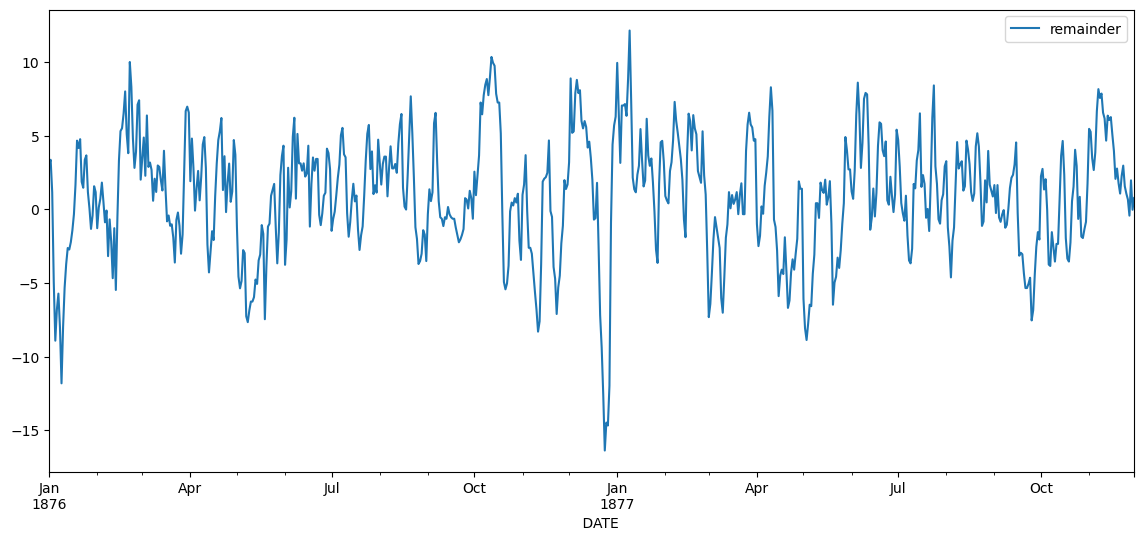

In [100]:
#consider only two years to get a better view on the data
dftrain.iloc[0:700,:][['remainder']].plot()

# 7) Start Autoregressive Model

We extract and model the remainder by means of an autoregressive model. 

In [101]:
dfrem = pd.DataFrame(dftrain['remainder'])

In [102]:
dfrem.head()

,remainder
DATE,
1876-01-01,3.078001
1876-01-02,3.377968
1876-01-03,1.177935
1876-01-04,-4.922098
1876-01-05,-8.922131


# 8)  Create time-lagged input feature: lag1

Lag = interval of time between related phenomena. In our case: remainder today and tomorrow are two related phenomena. Put lag1 info in new column.

In [106]:
dfrem['lag1'] = dfrem['remainder'].shift(1)

In [107]:
dfrem.head()

,remainder,lag1
DATE,,
1876-01-01,3.078001,NaN
1876-01-02,3.377968,3.078001
1876-01-03,1.177935,3.377968
1876-01-04,-4.922098,1.177935
1876-01-05,-8.922131,-4.922098


# 9) Inspect correlations

Inspect correlation between remainder and lag1 information.

In [108]:
dfrem.corr()

,remainder,lag1
remainder,1.000000,0.803864
lag1,0.803864,1.000000


# 10)  Plot remainder against lag1

We plot the remainder against lag1 information in order to get an idea on which model to use.

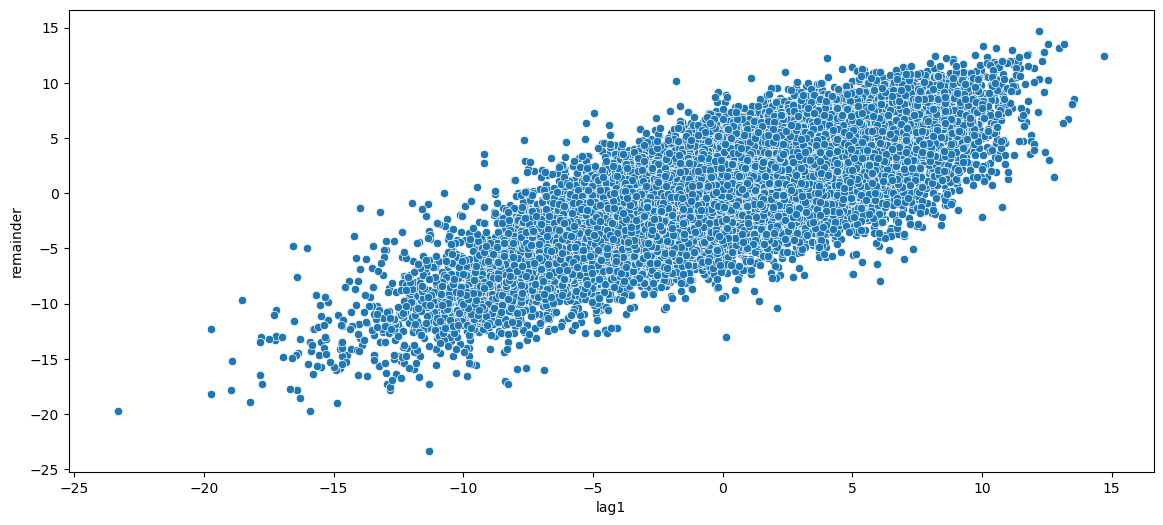

In [109]:
sns.scatterplot(x='lag1',y='remainder',data=dfrem);

$$y = wx + c$$

# 11) Run autoregression (Lin. Reg.) of lag1 on the remainder

In [110]:
#drop Nan Values (data of first day, as we do not have any lag1 data)
dfrem.dropna(inplace=True)
dfrem.head()

,remainder,lag1
DATE,,
1876-01-02,3.377968,3.078001
1876-01-03,1.177935,3.377968
1876-01-04,-4.922098,1.177935
1876-01-05,-8.922131,-4.922098
1876-01-06,-6.822164,-8.922131


In [111]:
#prepare our model input
X = dfrem[['lag1']]
y = dfrem['remainder']

In [112]:
#choose linear regression as model
m_autoreg = LinearRegression()
m_autoreg.fit(X,y)

LinearRegression()

In [113]:
#get info on intercept and coefficients of linear regression model
print(m_autoreg.coef_)
print(m_autoreg.intercept_)

[0.80391645]
0.00010496186893881607


In [114]:
#insert predicted model output to dataframe
dfrem['predictions_ar1'] = m_autoreg.predict(X)
dfrem.head()

,remainder,lag1,predictions_ar1
DATE,,,
1876-01-02,3.377968,3.078001,2.474561
1876-01-03,1.177935,3.377968,2.715709
1876-01-04,-4.922098,1.177935,0.947066
1876-01-05,-8.922131,-4.922098,-3.956850
1876-01-06,-6.822164,-8.922131,-7.172543


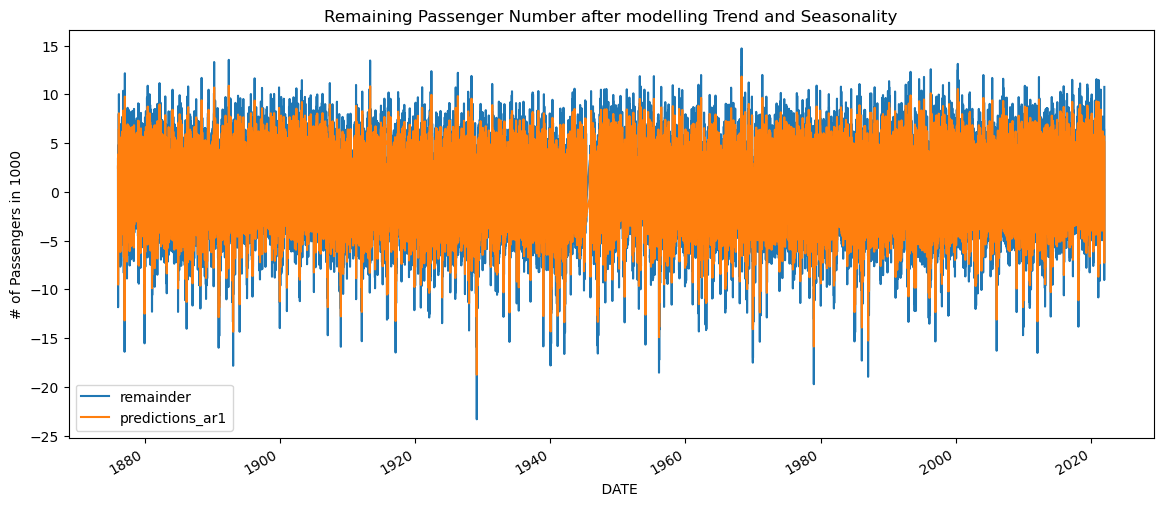

In [116]:
#plot remainder vs. predictions
plot_remainder(dfrem[['remainder','predictions_ar1']])

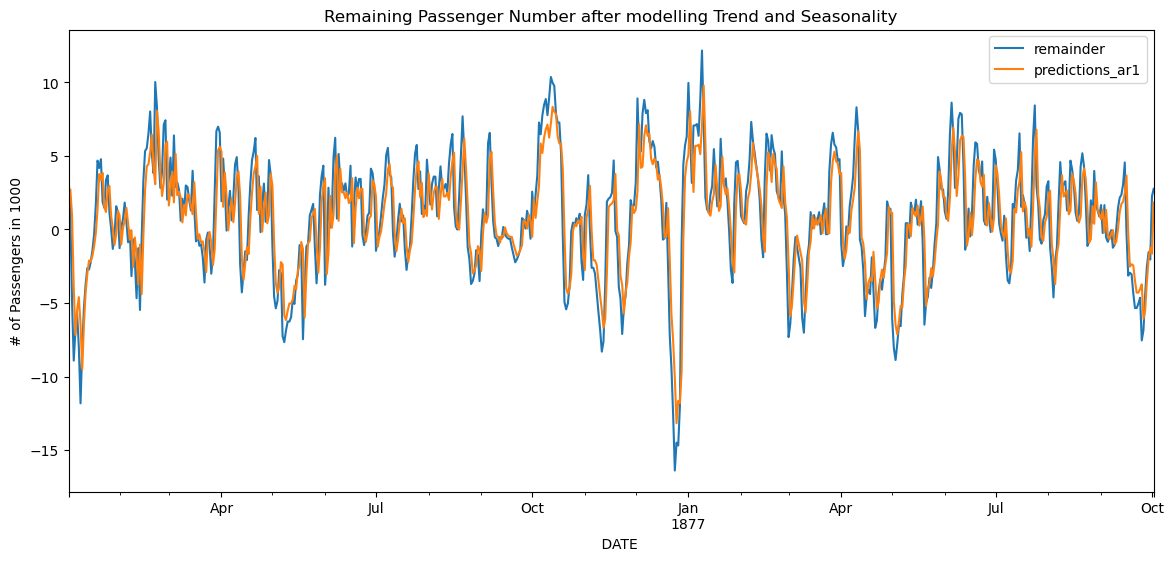

In [117]:
#plot remainder vs. predictions for two years to get a better view
plot_remainder(dfrem.iloc[0:640,:][['remainder','predictions_ar1']])

# 12) Try out lag2

Insert lag2 information and investigate correlations, then investigate the suggested number of lags to insert to the model.

In [118]:
dfrem['lag2'] = dfrem['remainder'].shift(2)
dfrem.head()

,remainder,lag1,predictions_ar1,lag2
DATE,,,,
1876-01-02,3.377968,3.078001,2.474561,NaN
1876-01-03,1.177935,3.377968,2.715709,NaN
1876-01-04,-4.922098,1.177935,0.947066,3.377968
1876-01-05,-8.922131,-4.922098,-3.956850,1.177935
1876-01-06,-6.822164,-8.922131,-7.172543,-4.922098


In [119]:
dfrem.dropna(inplace=True)

In [120]:
dfrem.head()

,remainder,lag1,predictions_ar1,lag2
DATE,,,,
1876-01-04,-4.922098,1.177935,0.947066,3.377968
1876-01-05,-8.922131,-4.922098,-3.956850,1.177935
1876-01-06,-6.822164,-8.922131,-7.172543,-4.922098
1876-01-07,-5.722197,-6.822164,-5.484345,-8.922131
1876-01-08,-8.022230,-5.722197,-4.600063,-6.822164


<AxesSubplot:xlabel='lag2', ylabel='remainder'>

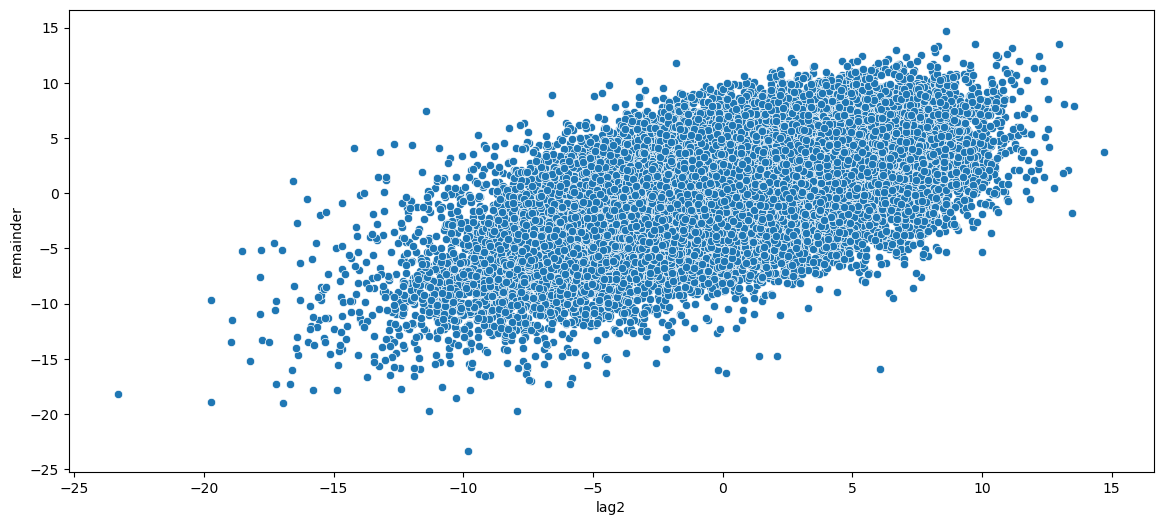

In [121]:
#plot lag2 vs. remainder to get an idea of the model we should use
sns.scatterplot(x=dfrem['lag2'],y=dfrem['remainder'],data=dfrem);

In [122]:
#inspect the correlations between lag information and remainder
round(dfrem[['remainder', 'lag1', 'lag2']].corr(), 2)

,remainder,lag1,lag2
remainder,1.0,0.8,0.6
lag1,0.8,1.0,0.8
lag2,0.6,0.8,1.0


Find perfect value for p (= number of lags) by means of statsmodel library

In [123]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

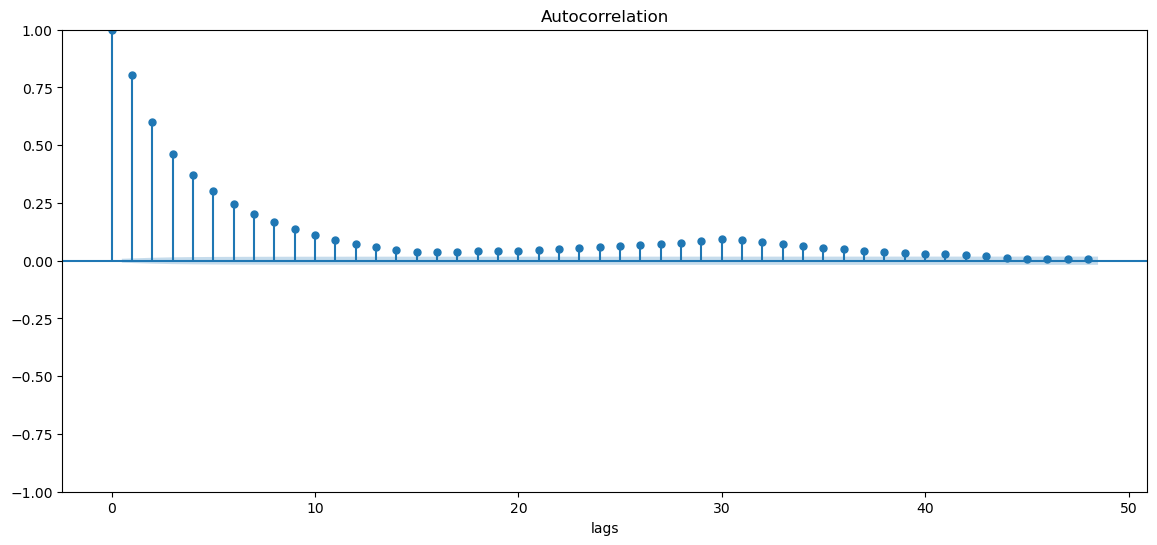

In [125]:
plot_acf(dftrain['remainder'])
plt.xlabel('lags');

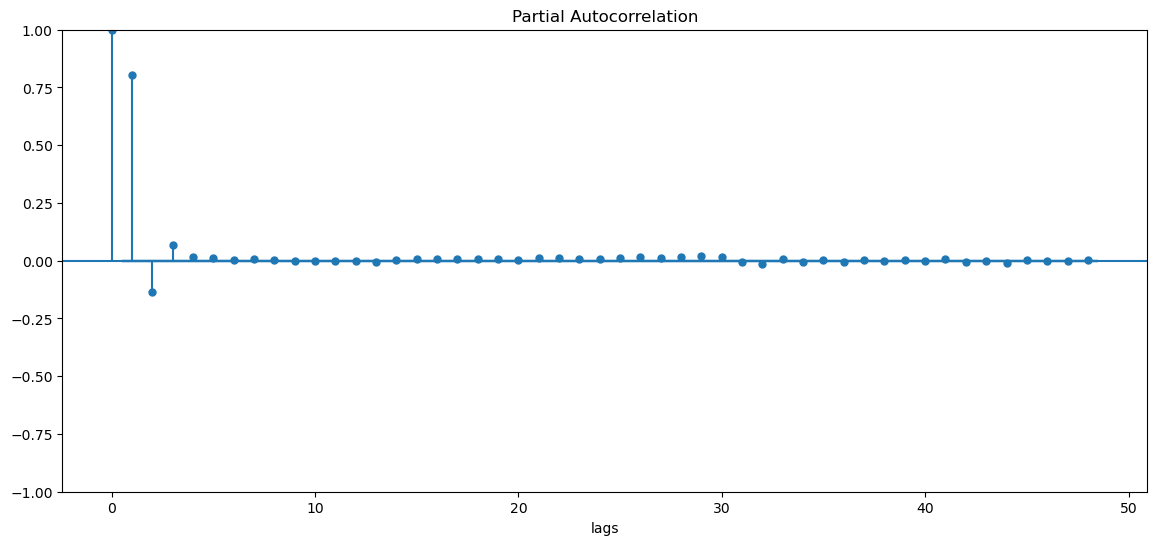

In [127]:
#plot partial autocorrelation function
plot_pacf(dftrain['remainder'])
plt.xlabel('lags');

In our model, we continue to choose lag1.

## 12.2) Statsmodels and ar_select_order

In [ ]:
selected_order = ar_select_order(dfrem['remainder'], maxlag = 12)

In [ ]:
selected_order.ar_lags

In [128]:
dfrem.head()

,remainder,lag1,predictions_ar1,lag2
DATE,,,,
1876-01-04,-4.922098,1.177935,0.947066,3.377968
1876-01-05,-8.922131,-4.922098,-3.956850,1.177935
1876-01-06,-6.822164,-8.922131,-7.172543,-4.922098
1876-01-07,-5.722197,-6.822164,-5.484345,-8.922131
1876-01-08,-8.022230,-5.722197,-4.600063,-6.822164


# 13) Make predictions on original training data

We add lag1 info to original training dataframe. Our aim is to adjust our original model.


In [130]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,,,
1876-01-01,22,2.2,0,0,0,0,0,0,0,0,0,0,0,0,8.499051,-0.878001,3.078001
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,8.499085,-0.877968,3.377968
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,8.499119,-0.877935,1.177935
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,8.499153,-0.877902,-4.922098
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,8.499186,-0.877869,-8.922131


In [131]:
dftrain['lag1'] = dftrain['remainder'].shift(1)
dftrain.dropna(inplace=True)

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/2656284986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain['lag1'] = dftrain['remainder'].shift(1)


In [135]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,,,
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,8.499085,-0.877968,3.377968,3.078001
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,8.499119,-0.877935,1.177935,3.377968
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,8.499153,-0.877902,-4.922098,1.177935
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,8.499186,-0.877869,-8.922131,-4.922098
1876-01-06,-77,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,8.499220,-0.877836,-6.822164,-8.922131


In [137]:
#prepare training data for model
Xtrain_full = dftrain.drop(columns=['TG','TG_scaled', 'trend_seasonal','trend', 'remainder'])
ytrain_full = dftrain['TG_scaled']

In [138]:
Xtrain_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0,3.078001
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0,3.377968
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0,1.177935
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.922098
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.922131


In [140]:
#choose linear regression to model full data
m_full = LinearRegression()
m_full.fit(Xtrain_full, ytrain_full)

LinearRegression()

In [141]:
#predict temperature and insert data to dataframe
dftrain['predictions_full_model'] = m_full.predict(Xtrain_full)

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/4074247049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain['predictions_full_model'] = m_full.predict(Xtrain_full)


In [142]:
dftrain.tail()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,
2021-12-27,-39,-3.9,53126,0,0,0,0,0,0,0,0,0,0,1,10.294610,2.234290,-6.134290,-9.034257,-5.005839
2021-12-28,-5,-0.5,53127,0,0,0,0,0,0,0,0,0,0,1,10.294644,2.234323,-2.734323,-6.134290,-2.674295
2021-12-29,45,4.5,53128,0,0,0,0,0,0,0,0,0,0,1,10.294678,2.234356,2.265644,-2.734323,0.059238
2021-12-30,93,9.3,53129,0,0,0,0,0,0,0,0,0,0,1,10.294711,2.234389,7.065611,2.265644,4.079136
2021-12-31,130,13.0,53130,0,0,0,0,0,0,0,0,0,0,1,10.294745,2.234422,10.765578,7.065611,7.938238


# 14) Plot prediction vs. temp for training data  + Evaluation of model

In [143]:
def plot_temp(df, title='Scaled temperature forecast', ylim=False):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('scaled temperature')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

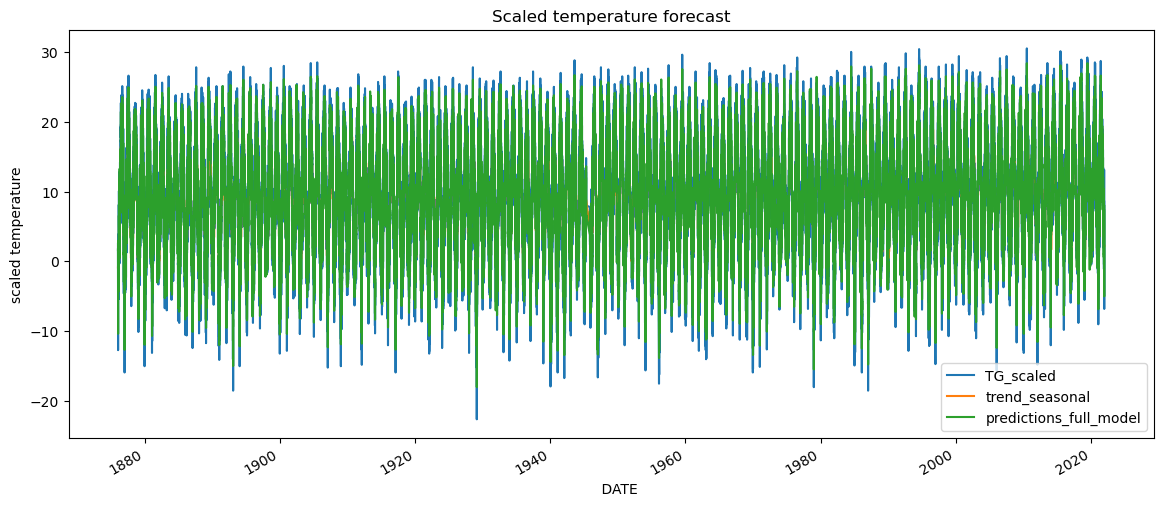

In [144]:
plot_temp(dftrain[['TG_scaled', 'trend_seasonal', 'predictions_full_model']])

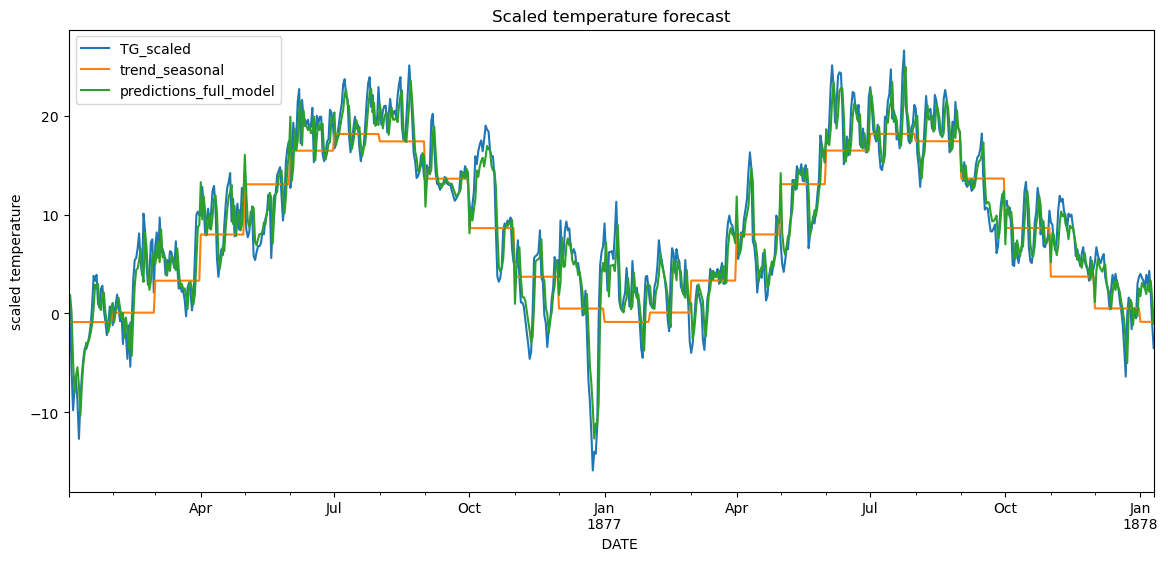

In [147]:
plot_temp(dftrain.iloc[0:740,:][['TG_scaled', 'trend_seasonal', 'predictions_full_model']])

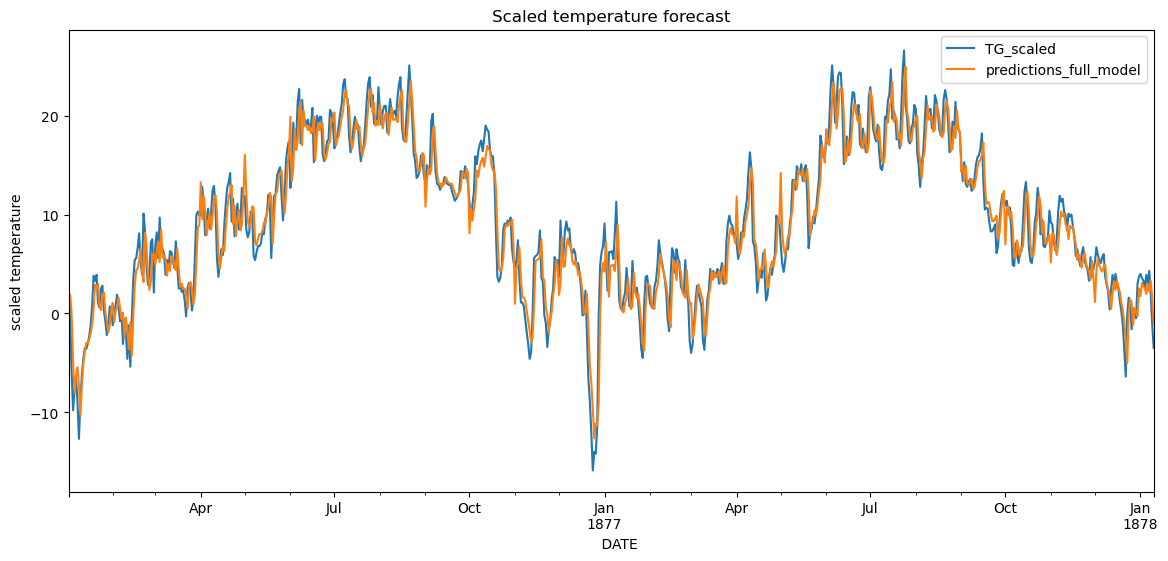

In [148]:
plot_temp(dftrain.iloc[0:740,:][['TG_scaled', 'predictions_full_model']])

In [149]:
#score the model's predictions
m_full.score(Xtrain_full,ytrain_full)

0.9120372965373377

# 15) Evaluate the model via cross validation

To use cross validation, we use a time series split that splits data based on the datetime information.

In [150]:
Xtrain_full.shape

(53130, 13)

In [151]:
#Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [152]:
#Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(Xtrain_full, ytrain_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 8852 8853 8854]
The validation data for the 1th iteration are the observations steps
    [ 8855  8856  8857 ... 17707 17708 17709]


The training data for the 2th iteration are the observations steps 
    [    0     1     2 ... 17707 17708 17709]
The validation data for the 2th iteration are the observations steps
    [17710 17711 17712 ... 26562 26563 26564]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 26562 26563 26564]
The validation data for the 3th iteration are the observations steps
    [26565 26566 26567 ... 35417 35418 35419]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 35417 35418 35419]
The validation data for the 4th iteration are the observations steps
    [35420 35421 35422 ... 44272 44273 44274]


The training data for the 5th iteration are the observations steps 
    [    0    

In [153]:
#Create the time series split
time_series_split = ts_split.split(Xtrain_full, ytrain_full) 

In [154]:
#Do the cross validation: These are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=Xtrain_full, y=ytrain_full,
                         cv=time_series_split)
result

array([0.90298255, 0.91057638, 0.91237963, 0.90729847, 0.91538953])

In [155]:
result.mean(), result.std()

(0.9097253101139675, 0.004271004305796251)

# 16) Test the model

We did the train-test-split after introducing the timestep and seasonal dummies. Thus, we have a well-prepared dataframe for testing.

In [156]:
dftest.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,
2022-01-01,120,12.0,53131,0,0,0,0,0,0,0,0,0,0,0
2022-01-02,99,9.9,53132,0,0,0,0,0,0,0,0,0,0,0
2022-01-03,89,8.9,53133,0,0,0,0,0,0,0,0,0,0,0
2022-01-04,64,6.4,53134,0,0,0,0,0,0,0,0,0,0,0
2022-01-05,38,3.8,53135,0,0,0,0,0,0,0,0,0,0,0


Now we do the same steps as for the train-part: 
- Predict trend and seasonality
- calculate remainder
- add the lag of remainder to original test-dataframe
- apply model with remainder lag as additional input feature

In [157]:
Xtest_seasonal = dftest.drop(columns=['TG', 'TG_scaled'])
ytest_seasonal = dftest['TG_scaled']

In [158]:
Xtest_seasonal.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
2022-01-01,53131,0,0,0,0,0,0,0,0,0,0,0
2022-01-02,53132,0,0,0,0,0,0,0,0,0,0,0
2022-01-03,53133,0,0,0,0,0,0,0,0,0,0,0
2022-01-04,53134,0,0,0,0,0,0,0,0,0,0,0
2022-01-05,53135,0,0,0,0,0,0,0,0,0,0,0


Predict trend + seasonality with trend_seasonal model

In [159]:
dftest['trend_seasonal'] = m_trend_seasonal.predict(Xtest_seasonal)
dftest.head()

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/503158894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['trend_seasonal'] = m_trend_seasonal.predict(Xtest_seasonal)


,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,,
2022-01-01,120,12.0,53131,0,0,0,0,0,0,0,0,0,0,0,0.877203
2022-01-02,99,9.9,53132,0,0,0,0,0,0,0,0,0,0,0,0.877236
2022-01-03,89,8.9,53133,0,0,0,0,0,0,0,0,0,0,0,0.877269
2022-01-04,64,6.4,53134,0,0,0,0,0,0,0,0,0,0,0,0.877302
2022-01-05,38,3.8,53135,0,0,0,0,0,0,0,0,0,0,0,0.877335


<AxesSubplot:xlabel='    DATE'>

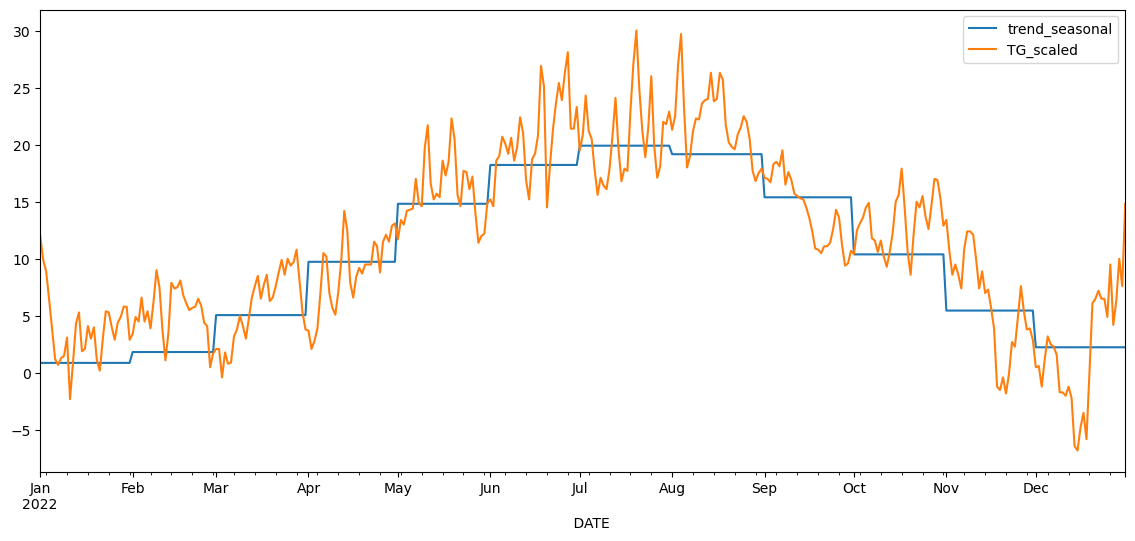

In [162]:
dftest[['trend_seasonal','TG_scaled']].plot()

Calculate Remainder and add lag of remainder to test dataframe

In [163]:
dftest['remainder'] = dftest['TG_scaled'] - dftest['trend_seasonal']

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/2651490527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['remainder'] = dftest['TG_scaled'] - dftest['trend_seasonal']


In [164]:
dftest['lag1'] = dftest['remainder'].shift(1)

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/1872234209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['lag1'] = dftest['remainder'].shift(1)


In [165]:
dftest.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,,
2022-01-01,120,12.0,53131,0,0,0,0,0,0,0,0,0,0,0,0.877203,11.122797,NaN
2022-01-02,99,9.9,53132,0,0,0,0,0,0,0,0,0,0,0,0.877236,9.022764,11.122797
2022-01-03,89,8.9,53133,0,0,0,0,0,0,0,0,0,0,0,0.877269,8.022731,9.022764
2022-01-04,64,6.4,53134,0,0,0,0,0,0,0,0,0,0,0,0.877302,5.522698,8.022731
2022-01-05,38,3.8,53135,0,0,0,0,0,0,0,0,0,0,0,0.877335,2.922665,5.522698


Set up new X and add missing value for first lag1 entry

In [167]:
Xtest_full = dftest.drop(columns=['TG','TG_scaled','trend_seasonal','remainder'])

In [168]:
Xtest_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
2022-01-01,53131,0,0,0,0,0,0,0,0,0,0,0,NaN
2022-01-02,53132,0,0,0,0,0,0,0,0,0,0,0,11.122797
2022-01-03,53133,0,0,0,0,0,0,0,0,0,0,0,9.022764
2022-01-04,53134,0,0,0,0,0,0,0,0,0,0,0,8.022731
2022-01-05,53135,0,0,0,0,0,0,0,0,0,0,0,5.522698


In [173]:
Xtest_full.loc['2022-01-01', 'lag1'] = dftrain.loc['2021-12-31','remainder']

In [174]:
Xtest_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
2022-01-01,53131,0,0,0,0,0,0,0,0,0,0,0,10.765578
2022-01-02,53132,0,0,0,0,0,0,0,0,0,0,0,11.122797
2022-01-03,53133,0,0,0,0,0,0,0,0,0,0,0,9.022764
2022-01-04,53134,0,0,0,0,0,0,0,0,0,0,0,8.022731
2022-01-05,53135,0,0,0,0,0,0,0,0,0,0,0,5.522698


Create predictions

In [175]:
dftest['predictions_full_model'] = m_full.predict(Xtest_full)

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/3414731815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['predictions_full_model'] = m_full.predict(Xtest_full)


In [176]:
dftest.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,
2022-01-01,120,12.0,53131,0,0,0,0,0,0,0,0,0,0,0,0.877203,11.122797,NaN,9.562430
2022-01-02,99,9.9,53132,0,0,0,0,0,0,0,0,0,0,0,0.877236,9.022764,11.122797,9.849659
2022-01-03,89,8.9,53133,0,0,0,0,0,0,0,0,0,0,0,0.877269,8.022731,9.022764,8.161311
2022-01-04,64,6.4,53134,0,0,0,0,0,0,0,0,0,0,0,0.877302,5.522698,8.022731,7.357340
2022-01-05,38,3.8,53135,0,0,0,0,0,0,0,0,0,0,0,0.877335,2.922665,5.522698,5.347400


**Score the model**

In [238]:
m_full.score(Xtest_full,dftest['TG_scaled'])

0.9125202403864368

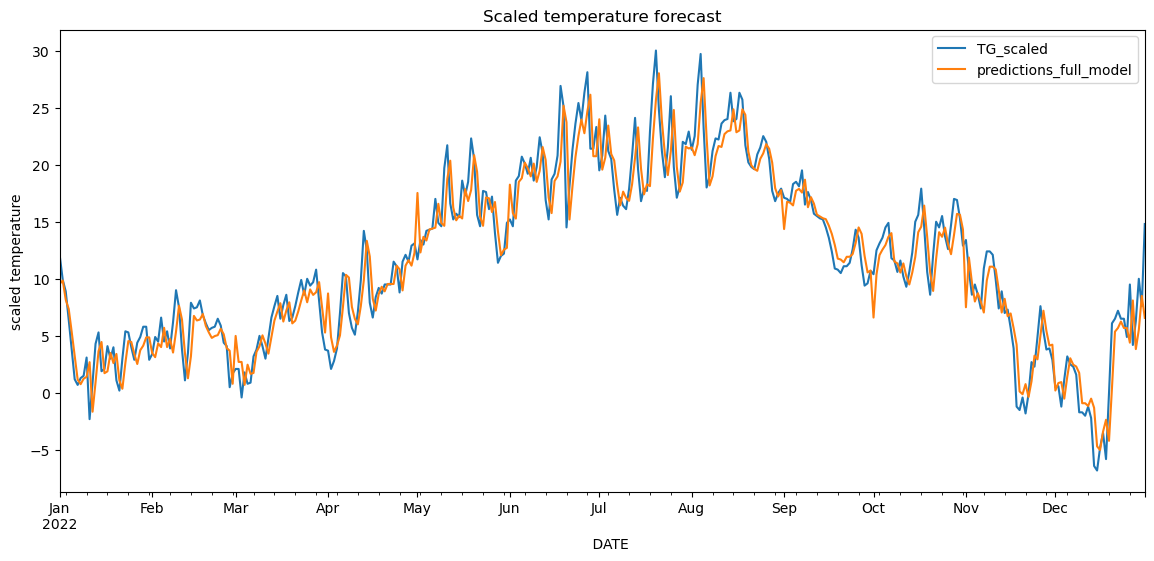

In [178]:
plot_temp(dftest[['TG_scaled', 'predictions_full_model']])

Create full dataset (train+test) and plot it 

In [180]:
df_full = dftrain[['TG_scaled', 'predictions_full_model']].append(dftest[['TG_scaled', 'predictions_full_model']])


/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/641046943.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = dftrain[['TG_scaled', 'predictions_full_model']].append(dftest[['TG_scaled', 'predictions_full_model']])


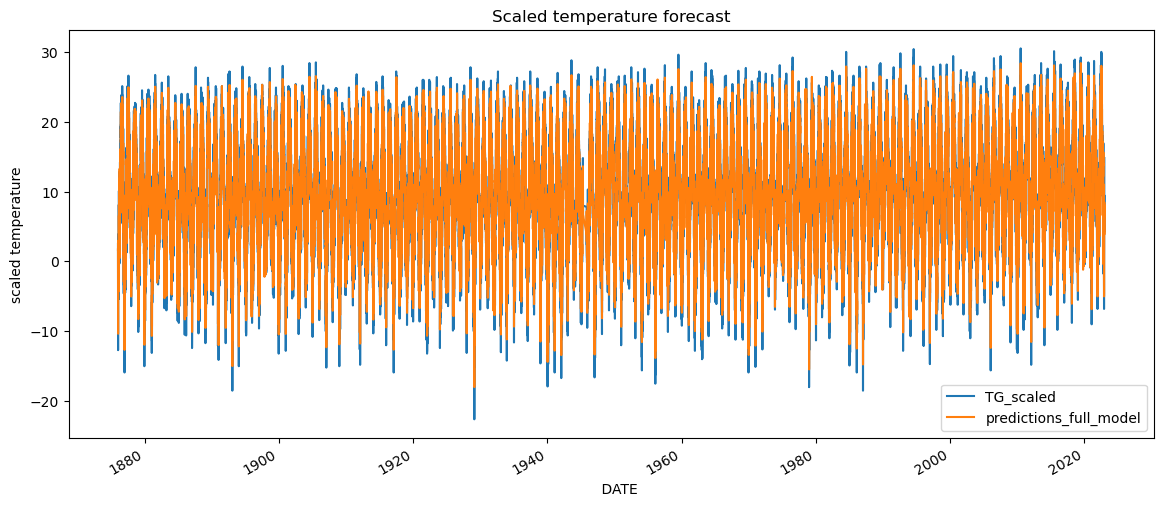

In [181]:
plot_temp(df_full[['TG_scaled', 'predictions_full_model']])

In [187]:
print(f"""
full model score = {m_full.score(Xtest_full, dftest['TG_scaled'])}
""")


full model score = 0.9125202403864368



**Use the augmented dickey fuller test to get overview on stationarity**

In [236]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [235]:
statsmodels.tsa.stattools.adfuller(dftrain['remainder'])

(-23.763813909621813,
 0.0,
 58,
 53071,
 {'1%': -3.4304732239136526,
  '5%': -2.8615944625086045,
  '10%': -2.566798988579998},
 239371.77421836878)

In [237]:
print_adf(dftrain['remainder'])

   
            adf: -23.76
            p: 0.0 
            used lag: 58 
            number of observations: 53071
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 239371.77421836878
            


**$\Rightarrow$ as p = 0 < 0.05, and adf < -3.43, we can state that the model is stationary - yay!**

# 17) Predict future

In what follows, we predict the temperature for a single day. Therefore, we retrain our model on the whole dataset, that is on train data combined with former test data. After doing so, we do prediction on new date and compare it to actual weather data on that day.

In [210]:
dftest.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,
2022-01-01,120,12.0,53131,0,0,0,0,0,0,0,0,0,0,0,0.877203,11.122797,10.765578,9.562430
2022-01-02,99,9.9,53132,0,0,0,0,0,0,0,0,0,0,0,0.877236,9.022764,11.122797,9.849659
2022-01-03,89,8.9,53133,0,0,0,0,0,0,0,0,0,0,0,0.877269,8.022731,9.022764,8.161311
2022-01-04,64,6.4,53134,0,0,0,0,0,0,0,0,0,0,0,0.877302,5.522698,8.022731,7.357340
2022-01-05,38,3.8,53135,0,0,0,0,0,0,0,0,0,0,0,0.877335,2.922665,5.522698,5.347400


In [209]:
dftest.loc['2022-01-01', 'lag1'] = dftrain.loc['2021-12-31','remainder']

In [189]:
dftrain.head()

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,8.499085,-0.877968,3.377968,3.078001,1.625065
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,8.499119,-0.877935,1.177935,3.377968,1.866265
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,8.499153,-0.877902,-4.922098,1.177935,0.097519
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,8.499186,-0.877869,-8.922131,-4.922098,-4.806742
1876-01-06,-77,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,8.499220,-0.877836,-6.822164,-8.922131,-8.022648


In [211]:
dfcomb = dftrain.drop(columns=['trend']).append(dftest)
dfcomb.head()

/var/folders/fx/z2htk6_n1z538kpcn3_52d140000gn/T/ipykernel_5546/169426973.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcomb = dftrain.drop(columns=['trend']).append(dftest)


,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,
1876-01-02,25,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.877968,3.377968,3.078001,1.625065
1876-01-03,3,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.877935,1.177935,3.377968,1.866265
1876-01-04,-58,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.877902,-4.922098,1.177935,0.097519
1876-01-05,-98,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.877869,-8.922131,-4.922098,-4.806742
1876-01-06,-77,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.877836,-6.822164,-8.922131,-8.022648


Retrain model on whole dataset

In [212]:
X_comb = dfcomb.drop(columns=['TG','TG_scaled','trend_seasonal','remainder','predictions_full_model'])
y_comb = dfcomb['TG_scaled']

In [213]:
X_comb.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0,3.078001
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0,3.377968
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0,1.177935
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.922098
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-8.922131


In [215]:
m_combined = LinearRegression()
m_combined.fit(X_comb,y_comb)

LinearRegression()

In [216]:
m_combined.coef_

array([3.32572869e-05, 9.61946711e-01, 4.18746609e+00, 8.81974976e+00,
       1.39030182e+01, 1.72737940e+01, 1.89798472e+01, 1.81974855e+01,
       1.44540190e+01, 9.45900159e+00, 4.56465745e+00, 1.35061871e+00,
       8.04059215e-01])

## 17.1) Create single future prediction

In [218]:
dfcomb.tail(1)

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,
2022-12-31,148,14.8,53495,0,0,0,0,0,0,0,0,0,0,1,2.24648,12.55352,5.353553,6.573849


In [219]:
# What is the first date in the future? --> 2023-01-01
timestep = dfcomb['timestep'].max() + 1
months = [0] * 11
lag = dfcomb.loc['2022-12-31', 'remainder']

In [220]:
timestep, months, lag

(53496, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 12.55352023177775)

In [225]:
X_future = [timestep]

X_future

[53496]

In [226]:
X_future.extend(months)
X_future

[53496, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [227]:
X_future.append(lag)
X_future

[53496, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.55352023177775]

In [228]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_comb.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,53496,0,0,0,0,0,0,0,0,0,0,0,12.55352


In [229]:
m_combined.predict(X_future)

array([11.02032035])

In [231]:
dfcomb.tail(1)

,TG,TG_scaled,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,
2022-12-31,148,14.8,53495,0,0,0,0,0,0,0,0,0,0,1,2.24648,12.55352,5.353553,6.573849


# 18) Interpretation:
The model predicts the temperature of 11.02 degrees Celcius for the day 01-01-2023. Let's compare to the true data we can look up at the internet: At Berlin Tempelhof, it has been 10.5 degrees Celcius on that date! That is, our prediction is quite close, YAY! 